In [34]:
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
# from umap import UMAP
from hdbscan import HDBSCAN
import numpy as np
import pandas as pd
import torch

import nltk
from nltk.tokenize import word_tokenize
# nltk.download('punkt_tab')

In [2]:
# transfer learning:

# how to check out of vocabulary (OOV) tokens
# from transformers import AutoTokenizer, AutoModel

# tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# # tokenize sentences
# tokens = tokenizer.tokenize("Your custom sentence with domain-specific terms")

# # check tokens
# vocab = tokenizer.get_vocab()
# oov_tokens = [token for token in tokens if token not in vocab]

# model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# new_tokens = ["mynewword1", "mynewword2", "customterm"]
# tokenizer.add_tokens(new_tokens)
# model.resize_token_embeddings(len(tokenizer))

# or Pretrain on Masked Language Modeling (MLM)

In [3]:
# Start with the default English stop words
custom_stop_words = list(text.ENGLISH_STOP_WORDS)+['sa','supplemental_agreement','standard','accordance','written','specifications','north','carolina','work','article','shall']


In [4]:
# 1. Load a pretrained Sentence Transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# embedding_model = SentenceTransformer("thenlper/gte-small")

In [20]:
# Import supplemental agreement data
cra_sa_agg=pd.read_csv('/Users/tawate/Documents/cra_sa_agg.csv', encoding='latin1', on_bad_lines='skip')

(16256, 45)
Index(['contract_nbr', 'work_order_nbr', 'tip_nbr', 'contract_mod_type_cd',
       'contract_mod_nbr', 'contract_mod_nbr_c', 'sa_status_cd',
       'sa_status_desc', 'sa_reason_desc', 'cm_type_of_work_cd',
       'cm_type_of_work_desc', 'sa_specification_cd', 'sa_mod_desc',
       'sa_justification_desc', 'contract_time_consider_ind',
       'contract_time_no_ext_ind', 'overall_ct_ind', 'sa_key',
       'billing_status', 'division', 'region', 'group', 'project_type',
       'contract_bid_amt', 'contract_bid_amt_category', 'calendar_days',
       'contract_desc', 'letting_dt', 'type_of_contract',
       'sa_specification_desc', 'sa_specification_cd_desc_mod',
       'sa_time_ext_cmnt', 'time_affected_work_cd',
       'time_affected_work_type_desc', 'overall_contract_time_nbr',
       'vep_sa_desc', 'cmgc_megasite_flg', 'decision_date', 'li_count',
       'wbs_count', 'sa_cost', 'sa_cost_wo', 'sa_time_extension',
       'extracted_intro', 'sa_specification_label'],
      dtyp

contract_nbr                        0
work_order_nbr                      0
tip_nbr                          5350
contract_mod_type_cd                0
contract_mod_nbr                    0
contract_mod_nbr_c                  0
sa_status_cd                        0
sa_status_desc                      0
sa_reason_desc                      0
cm_type_of_work_cd                  0
cm_type_of_work_desc                0
sa_specification_cd                 0
sa_mod_desc                         0
sa_justification_desc             289
contract_time_consider_ind        290
contract_time_no_ext_ind          290
overall_ct_ind                  13296
sa_key                              0
billing_status                      0
division                            0
region                              0
group                            1053
project_type                      150
contract_bid_amt                    0
contract_bid_amt_category           0
calendar_days                      28
contract_des

In [28]:
# cra_sa_agg['sa_mod_desc'] = cra_sa_agg['sa_mod_desc'].str.replace(r"material escalation", "material_escalation", case=False, regex=True)
cra_sa_agg['sa_mod_desc'] = cra_sa_agg['sa_mod_desc'].str.replace(r"material shortage", "material_shortage", case=False, regex=True)
cra_sa_agg['sa_mod_desc'] = cra_sa_agg['sa_mod_desc'].str.replace(r"time-limited", "time_limited", case=False, regex=True)
cra_sa_agg['sa_mod_desc'] = cra_sa_agg['sa_mod_desc'].str.replace(r"supplemental agreement", "supplemental_agreement", case=False, regex=True)


In [7]:
# import re

# def replace_phrases(df, column, phrase_dict):
#     for phrase, replacement in phrase_dict.items():
#         df[column] = df[column].str.replace(
#             re.escape(phrase), replacement, case=False, regex=True
#         )
#     return df


# # Define phrases to replace
# phrases = {
#     "material escalation": "material_escalation",
#     "project delay": "project_delay",
#     "quality issues": "quality_issues"
# }

# # Apply the function
# df = replace_phrases(df, 'text_column', phrases)

In [29]:
import re
# repeat initial phrases to emphasize. 
stop_phrases = r"(In accordance with|The Supplemental_Agreement|This supplemental_agreement|The following supplemental_agreement|This SA|This agreement|Supplemental_Agreement)"

# Function to extract text before any of the stop phrases
def extract_intro(text):
   match = re.split(stop_phrases, text, maxsplit=1, flags=re.IGNORECASE)
   # match = re.split(r"(^.*(\-|\)|\:|\.))", match[0], maxsplit=1, flags=re.IGNORECASE)
   # match2 = re.match(r'^([^\.\:\-\)]+)', match[0])
   # if match2:
   #    results=match2.group(1).strip()
   # else:
   #    results=None
   return match[0].strip()

# Apply it to your column
cra_sa_agg['extracted_intro'] = cra_sa_agg['sa_mod_desc'].apply(extract_intro)
cra_sa_agg['sa_mod_desc'] = cra_sa_agg['extracted_intro'] + '. ' + cra_sa_agg['sa_mod_desc']

In [9]:
# cra_sa_agg['extracted_intro'].value_counts()

In [10]:
# cra_sa_agg['extracted_intro'].value_counts().to_csv('C:\\Users\\humcgh\\Downloads\\intro.csv')

In [30]:
sentences=cra_sa_agg['sa_mod_desc'].tolist()
len(sentences)
# Calculate the average length of strings in the list
average_length = sum([len(string) for string in sentences]) / len(sentences)

# Print the result
print("The Average length of String in list is:", average_length)

The Average length of String in list is: 1125.8296013779527


In [31]:
from sklearn.preprocessing import LabelEncoder
# Create an instance of LabelEncoder
le = LabelEncoder()
# cra_sa_agg['sa_specification_label'] = le.fit_transform(cra_sa_agg['sa_specification_desc'])
# # set to nan for unsupervised
# cra_sa_agg.loc[pd.isna(cra_sa_agg['sa_specification_desc']),'sa_specification_label'] = None

# labels=cra_sa_agg['sa_specification_label'].tolist()
# len(labels)

# Create a unique list of values including None
unique_vals = pd.Series(cra_sa_agg['sa_specification_desc'].unique())
# Create a mapping dictionary, assigning -1 to None
label_map = {val: idx if pd.notna(val) else -1 for idx, val in enumerate(unique_vals)}

# Apply the mapping
cra_sa_agg['sa_specification_label'] = cra_sa_agg['sa_specification_desc'].map(label_map)

labels=cra_sa_agg['sa_specification_label']
labels=labels.fillna(-1)

In [13]:
# # The description to encode
# sentences = [
# "Guardrail ReLapping. The Department has found it necessary due to the phasing of the project to relapp some of the guardrail after shifting traffic. All work shall be in accordance with Section 869 of the 2006 North Carolina Standard Specifications.This supplemental agreement is written to cover all cost associated with materials, labor, equipment, and incidentals. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Sound Wall Panel Replacement - The Department has agreed to split the cost of replacing the defective Paragon sound wall panels with the Contractor. The original panels have failed in that the paint applied to them when they were produced is not adhering to material beneth.  These failures are widespread and are showing on all three of the installed sound walls.  This supplemental agreement is written to cover all costs of materials, labor, equipment and incidentals associated with the removal and disposal of the Paragon sound wall panels and replacing them with Carsonite Composite sound wall panels. The work of sound wall replacement shall be in accordance with the  contract special provisions. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Guardrail Fixes. The Department agreed by letter dated August 9, 2016 to pay for any damage that occurred by traffic being placed in the area of the Haw River. This supplemental agreement is written to cover the cost incurred to the contractor to repair the guardrail on the I-73 portion of the project from a vehicular accident. This supplemental agreement is written to cover all cost of materials, labor, equipment, traffic control and incidentals associated with the replacement of the Impact Attenuator and cable guiderail anchor. All work shall be in accordance with section 862 and section 864 of the 2006 North Carolina Standard Specification. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Wingwalls. The Department has found that it is necessary  to cut the old bridge wing walls and leave them in place instead of removing them from Lake Bryant, this supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with cutting and patching of the old wing walls at structure 3A on the R-2309AB project. This supplemental agreement is written in accordance with article 104-7 of the 2012 North Carolina Standard Specifications.",
# "North End Traffic Shift. The Department requested that the Contractor coordinate with the Contractor on the adjoining project (C203645) to switch traffic to the southbound lanes on both projects at the same time. Tetra Tech was ready to place traffic on the new lanes before the adjoining project. This supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with the traffic shift. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "The following supplemental agreement is to establish the materials and payment needed for the following items: SNOWPLOWABLE PAVEMENT MARKERS (SEC. 1253).These prices will be full compensation for all equipment, labor, and material necessary for the satisfactory completion of the work.",
# "Sign Revision. The Department has revised the signing plans of the project.  This supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with the new signing plans.  All work shall be in accordance with Division 9 of the 2006 North Carolina Standard Specifications. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Overruns. The Contractor has requested under article 104-5 of the 2006 North Carolina Standard Specifications for a price increase due to the overrun of a minor item. The additional cost is due to increase in fuel price, labor rates, additional mobilizations and additional traffic control. This supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with the overruns involved in this supplemental agreement. All work shall be in accordance with the contract, 2006 North Carolina Standard Specification and project special provisions. This supplemental agreement is written in accordance with article 104-5 of the 2006 North Carolina Standard Specifications.",
# "SNOWPLOWABLE MARKERS: This supplemental agreement is written in accordance with Article 104-3 of the 2012 Standard Specifications for Altered Work.  This agreement establishes compensation for the material, equipment, labor and associated costs to furnish and install snowplowable markers in lieu of raised pavement markers throughout the project.  The work and materials will be performed in accordance with Section 1253 of the 2012 Standard Specifications for Snowplowable Pavement Markers.",
# "Signal Revision. The Department has revised the signal plans for the project.  This plan revision had made it necessary for the contractor to install a Conduit Entrance into Existing Foundation and a Field Ethernet Switch for Traffic Signal. This supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with the new signal plans.  All work shall be in accordance with Division 17 of the 2006 North Carolina Standard Specifications. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Overruns. The Contractor has requested under article 104-5 of the 2006 North Carolina Standard Specifications for a price increase due to the overrun of a minor item. The additional cost is due to increase in fuel price, labor rates, additional mobilizations and additional traffic control. This supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with the overruns involved in this supplemental agreement. All work shall be in accordance with the contract, 2006 North Carolina Standard Specification and project special provisions. This supplemental agreement is written in accordance with article 104-5 of the 2006 North Carolina Standard Specifications.",
# "GUARDRAIL: This supplemental agreement is written in accordance with Article 104-7 of the 2012 Standard Specifications for Extra Work.  This agreement establishes compensation for the material, equipment, labor and associated costs to furnish and install additional guardrail as outlined in the construction revision dated 06/09/2016 on roadway plan sheets 2-A, 5 and 7-12 (sent electronically to contractor on 06/22/2016).  The work and materials will be performed in accordance with Section 862 of the 2012 Standard Specifications for Guardrail.",
# "Guardrail Anchor Unit. The Department has found that the type of anchor units specified in the plan sheets at 2 locations will not work due to the presence of a drainage structure. A third location due to the configuration of the roadway the type of anchor unit would not fit. This supplemental agreement is written to cover all cost of labor, materials, equipment and incidentals associated with the installation of 2, 42 inch wide gating impact attenuator and 1, 96 inch wide gating impact attenuator. All work shall be in accordance with the manufactures specifications. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Overruns. The Contractor has requested under article 104-5 of the 2006 North Carolina Standard Specifications for a price increase due to the overrun of a minor item. The additional cost is due to increase in fuel price, labor rates, additional mobilizations and additional traffic control. This supplemental agreement is written to cover all cost of materials, labor, equipment and incidentals associated with the overruns involved in this supplemental agreement. All work shall be in accordance with the contract, 2006 North Carolina Standard Specification and project special provisions. This supplemental agreement is written in accordance with article 104-5 of the 2006 North Carolina Standard Specifications.",
# "UNIT PRICE CHANGE GUARDRAIL MASH COMPLIANCE- This supplemental agreement is written as an agreement between the Contractor, Onslow Grading and Paving, and the North Carolina Department of Transportation [NCDOT],  in accordance with Article 104-3 of the 2012 Standard Specifications for Roads and Structures.  This supplemental agreement is written to provide compensation to the Contractor for the following; unit price change in contract line items; 59 Steel Beam Guardrail, 60 Steel Beam Guardrail, Shop Curved, 62 Guardrail Anchor Units, Type AT-1, 63 Guardrail Anchor Units, CAT-1 & deletion of line items 64 Guardrail Anchor Units, Type 350, 65 Guardrail Anchor Units, Type M-350, & creation of new line item  GREU-Type 350, TL-3 Mash STD.  All work shall be performed in accordance with the 2012 Standard Specifications for Roads and Structures. This agreement provides full compensation for contractor s equipment, material, labor and incidentals to complete this work and will be measured and paid in accordance with the applicable 2012 Standard Specifications for each item established herein.  NCDOT will provide Survey Control for work associated with this Supplemental Agreement.",
# "Water Blasting. The Department has found requested that the contractor use water blasting instead of grinding to remove the temporary pavement markings on the bridges. This supplemental agreement is written to cover all cost associated with labor, material, equipment and incidentals to remove the temporary pavement markings by water blasting. All work shall be in accordance with Section 1205 of the 2006 North Carolina Standard Specifications. This supplemental agreement is written in accordance with article 104-7 of the 2012 North Carolina Standard Specifications.",
# "Guardrail Fixes. The Department agreed by letter dated August 9, 2016 to pay for any damage that occurred by traffic being placed in the area of the Haw River. This supplemental agreement is written to cover the cost incurred to the contractor to replace the impact attenuator and cable guiderail anchor block at the split of US 200 and I-73 from a vehicular accident. This supplemental agreement is written to cover all cost of materials, labor, equipment, traffic control and incidentals associated with the replacement of the Impact Attenuator and cable guiderail anchor. All work shall be in accordance with section 862 and section 864 of the 2006 North Carolina Standard Specification. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "MAST ARM FOUNDATION MODIFICATION- This agreement is written in accordance with Article 104-7 of the 2012 Standard Specifications for Roads and Structures and provides compensation for installation of the modified mast arm foundations at the intersection of NC 53 & Pony Farm/Murrill Hill.  Revised foundation plan sheets are attached.    All work shall be performed in accordance with the 2012 Standard Specifications for Roads and Structures, or as established herein. This agreement provides full compensation for equipment, material, labor and incidentals to complete this work and will be measured and paid in accordance with the applicable 2012 Standard Specifications for each item established herein, or as detailed below. NCDOT will provide survey control for this work.  This agreement adds the line item MAST ARM FOUNDATION.  This modification is necessary at plan locations 2, 3, & 4 of the signal plans (Attached).  This agreement is necessary due to the soil conditions not being able to support a traditional drilled shaft foundation at these locations.  An alternative (shaft & spread hybrid foundation) design was submitted and approved. (Attached).  MAST ARM FOUNDATION will be measured and paid in units of EACH, meeting the approved design drawing dimensions and specified numbers and lengths of reinforcing steel and anchor bolts per plan.    The line item FLOWABLE FILL MAST ARM FOUNDATION, shall be used prior to the installation of the mast arm foundation.  Flowable fill will be installed 6  in diameter at a depth 2 feet 6 inches below plan depth of the mast arm foundations, at plan locations 2, 3 and 4, in a wet pour, utilizing slurry for hole stability.  This material will be drilled out, with the remaining hardened material serving as a form to prevent these poor soils from collapse during drilling and pouring the mast arm foundation.  Measurement and payment will be the actual number of cubic yards placed in the in these 3 locations.  This will included all equipment, labor, material and incidentals necessary to complete the installation as approved by the Engineer.    Due to the poor soil conditions at this location, the subcontractor must perform this mast arm foundation installation in two separate operations which warrants an additional mobilization payment.  The flowable fill must reach a compressive strength of 500psi to 600psi prior to drilling for the mast arm foundation.    Signal Cabinet: Furnish and install base-mounted signal cabinet in accordance with Section 1751 of the 2012 Standard Specification for Roads & Structures, and provide and install new underground service.  Signal Cabinet Foundations, comply with Section 1750 of the 2012 Standard Specification for Roads & Structures.  Cabinet Base Adapter/Extender, comply with Section 1753 of the 2012 Standard Specification for Roads & Structures.  Removal of existing cabinet, foundation and CCTV pole, will be measured and paid lump sum.",
# "Owl s Roost Back Signals. The Department has requested that the Contractor install back signals at Owl s Roost Rd. This supplemental agreement is written to cover all cost of materials, labor, equipment, traffic control and incidentals associated with the back signals. The work of back signals shall be in accordance with Section 1705 of the 2006 North Carolina Standard Specifications. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "Repair of Slope Protection. The Department has found some washing that has occurred in the slope protection from the deck drains at the structures over the Haw River and has requested The Contractor to fill the voids with grout and repair/replace the rip rap slope protection. This supplemental agreement is written to cover all cost of labor, materials, equipment and incidentals associated with the grouting and repair of slope protection. This supplemental agreement is written in accordance with article 104-7 of the 2006 North Carolina Standard Specifications.",
# "PIPE COLLAR - This agreement is written in accordance with Article 104-7 of the 2012 Standard Specifications for Roads and Structures and provides compensation for construction and installation of Pipe Collars at Sta.# 26+86 +/-  -L1- as detailed in Section 840 of the 2012 Standard Specifications for Roads and Structures.   This agreement provides full compensation for labor, equipment, materials & incidentals for excavation, construction, and backfill of pipe collar(s) at specified locations. This SA creates a new line code (192)  Pipe Collar . Measurement and payment will be the cubic yards incorporated in the completed work, as shown/detailed in Standard Drawing 840.72.  Placing and finishing of this material will be at no cost to the department.  All concrete will be tested and sampled according to NCDOT procedures by NCDOT RE staff.  NCDOT will provide survey control for this work."
# ]

In [32]:
# # split the cra_sa_agg into text to encode;
# sentences = [sent_tokenize(description) for abstract in description]
# sentences = [sentence for doc in sentences for sentence in doc]

# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(sentences)
print(embeddings.shape)

# 3. Calculate the embedding similarities
# similarities = embedding_model.similarity(embeddings, embeddings)
# print(similarities)

(16256, 384)


In [15]:
# # Encode the corpus and the query
# corpus_embeddings = torch.tensor(embeddings, dtype=torch.float)
# # corpus_embeddings = embedding_model.encode(cra_sa_agg['sa_mod_desc'], convert_to_tensor=True)
# query_embedding = embedding_model.encode("weather", convert_to_tensor=True)

# # Compute cosine similarity
# cosine_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]

# # Add similarity scores to DataFrame
# cra_sa_agg['similarity'] = cosine_scores.cpu().numpy()

# # Sort and display
# cra_sa_agg = cra_sa_agg.sort_values(by='similarity', ascending=False)
# print(cra_sa_agg[['sa_mod_desc', 'similarity']])

In [33]:
# Step 1: Tokenize all sentences and collect unique words
unique_words = set()
for sentence in cra_sa_agg['sa_mod_desc']:
    words = word_tokenize(sentence)
    unique_words.update(words)

# Step 2: Encode all unique words once
unique_word_embeddings = {
    word: embedding_model.encode(word, convert_to_tensor=True) for word in unique_words
}

# Step 3: Encode the concept word
concept_embedding = embedding_model.encode("settle", convert_to_tensor=True)

# Step 4: Function to find weather-related words
def find_weather_related_words(sentence, threshold=0.4):
    words = word_tokenize(sentence)
    related_words = []
    for word in words:
        if word in unique_word_embeddings:
            similarity = util.pytorch_cos_sim(concept_embedding, unique_word_embeddings[word])[0][0]
            if similarity > threshold:
                related_words.append(word)
    return related_words

# Step 5: Apply to DataFrame
cra_sa_agg['settle_related_words'] = cra_sa_agg['sa_mod_desc'].apply(find_weather_related_words)

# Filter rows where weather-related words are found
filtered_df = cra_sa_agg[cra_sa_agg['settle_related_words'].map(len) > 0]

# print(filtered_df[['sa_mod_desc', 'escalation_related_words']])


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/tawate/nltk_data'
    - '/Users/tawate/Documents/ml_python_courses/.venv/nltk_data'
    - '/Users/tawate/Documents/ml_python_courses/.venv/share/nltk_data'
    - '/Users/tawate/Documents/ml_python_courses/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [19]:
# Extract unique weather-related words across all rows
unique_weather_related_words = set(word for words in cra_sa_agg['settle_related_words'] for word in words)

print("Unique material-related words:", unique_weather_related_words)

# # Display result
# filtered_df['weather_related_words'].value_counts().to_csv('C:\\Users\\humcgh\\Downloads\\info.csv')

Unique material-related words: {'kill', 'move', 'payout', 'Signed', 'equal', 'Peace', 'ROLLING', 'tolerances', 'accepting', 'settle', 'establishs', 'mature', 'commit', 'roll', 'Negotiated', 'living', 'satisfy', 'Negotiations', 'landed', 'REMAIN', 'Proceed-', 'Lime', 'mixes', 'SHAKE', 'tolerance', 'Roll', 'Mix-', 'pay', 'reaching', 'Detention', 'Agreements', 'FLUSHING', 'shake', 'situ', 'Moving', 'disperse', 'signing', 'commitments', 'jurisdiction', 'MIx', 'engage', 'Bunch', 'Mixed', 'MIX', 'flushing', 'clearing', 'accommodated', 'punch', 'proceed', 'negotiation', 'floored', 'respect', 'frozen', 'acceptance', 'CLEARING', 'Dig', 'match', 'land', 'decide', 'live', 'knock', 'Rolled', 'committed', 'fulfill', 'dig', 'agreement.All', 'spread', 'diluent', 'suppling', 'bit', 'payment', 'Proceed', 'Agreement.A', 'JUSTICE', 'Flush', 'Bump', 'acceptance/punch', 'PUNCH', 'settlement', 'Frozen', 'settlements', 'Floor', 'Compensate', 'Corrections', 'cope', 'negotiating', 'Payment-', 'Land', 'negotiat

In [20]:
# reduce embeddings from 384 to some n;
# umap_model = UMAP(n_components=10, min_dist=0.0, metric='cosine', random_state=42)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1, metric='cosine', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)
print(reduced_embeddings.shape)

(15200, 5)


In [53]:
# cluster embeddings the lower the number the more topics will be available
hdbscan_model = HDBSCAN(min_cluster_size=50, min_samples=5, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_
print(clusters.shape)

(15200,)


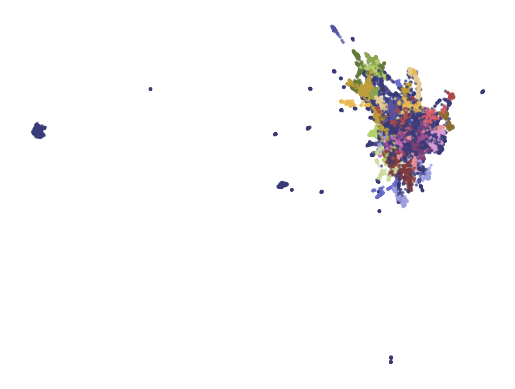

In [54]:
import matplotlib.pyplot as plt
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='tab20b', alpha=0.6, s=2)
plt.axis("off")
plt.show()

In [55]:
# remove stopwords, exclude infrequent words and use word pairs
vectorizer_model = CountVectorizer(stop_words=custom_stop_words, min_df=2, max_df=.9, ngram_range=(1, 2), token_pattern=r'(?u)\b(?=\w*[A-Za-z])\w+\b')
X = vectorizer_model.fit_transform(sentences)
# vectorizer_model = CountVectorizer(stop_words=custom_stop_words, min_df=2, ngram_range=(1, 2))
# vectorizer_model = CountVectorizer(stop_words="english", min_df=2, max_df=.9, ngram_range=(1, 2), token_pattern=r'(?u)\b(?=\w*[A-Za-z])\w+\b')

In [24]:
# # Fit and transform the corpus
# X = vectorizer_model.fit_transform(sentences)

# words = vectorizer_model.get_feature_names_out()

# # Sum the occurrences of each word
# word_counts = np.asarray(X.sum(axis=0)).flatten()

# # Sort words by frequency
# sorted_indices = np.argsort(word_counts)[::-1]
# most_frequent_words = [(words[i], word_counts[i]) for i in sorted_indices]

# # Print the most frequent words
# print("Most frequent words in the corpus:")
# for word, count in most_frequent_words:
#    print(f"{word}: {count}")


In [56]:
topic_model = BERTopic(embedding_model=embedding_model, 
                       umap_model=umap_model, 
                       hdbscan_model=hdbscan_model, 
                       vectorizer_model=vectorizer_model,
                       top_n_words=20,
                       verbose=True)
topics, probs = topic_model.fit_transform(sentences, embeddings)

2025-05-20 13:59:15,251 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2025-05-20 13:59:25,912 - BERTopic - Dimensionality - Completed ✓
2025-05-20 13:59:25,912 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 13:59:26,226 - BERTopic - Cluster - Completed ✓
2025-05-20 13:59:26,227 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 13:59:28,554 - BERTopic - Representation - Completed ✓


In [57]:
# import nbformat
topic_model.visualize_barchart(top_n_topics=10)


In [58]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3658,-1_asphalt_pipe_drainage_design,"[asphalt, pipe, drainage, design, course, stru...",[(Southern Paving Limits Extension). (Southern...
1,0,887,0_marking_pavement marking_pavement_markings,"[marking, pavement marking, pavement, markings...","[6"" and 12"" THERMOPLASTIC PAVEMENT MARKING LIN..."
2,1,641,1_water_waterline_water line_valve,"[water, waterline, water line, valve, relocati...",[6 WATER LINE TO 8 WATER LINE ADJUSTMENT -. 6 ...
3,2,502,2_signal_conduit_cable_fiber,"[signal, conduit, cable, fiber, cabinet, junct...","[FIBER OPTIC, RADIO INSTALLATION, ETHERNET CAB..."
4,3,476,3_sewer_manhole_manholes_sanitary,"[sewer, manhole, manholes, sanitary, boxes, sa...","[SANITARY SEWER CLEANOUT, ADJUSTMENT OF METER/..."
...,...,...,...,...,...
65,64,53,64_geotextile_stabilization_soil stabilization...,"[geotextile, stabilization, soil stabilization...","[Geotextile for Soil Stabilization, Type 5 and..."
66,65,52,65_guardrail_repairs_guiderail_guardrail repairs,"[guardrail, repairs, guiderail, guardrail repa...",[(Guardrail Repairs). (Guardrail Repairs) Thi...
67,66,51,66_vep_value engineering_engineering proposal_...,"[vep, value engineering, engineering proposal,...",[Value Engineering Proposal (VEP).. Value Engi...
68,67,50,67_hurricane_debris_matthew_hurricane matthew,"[hurricane, debris, matthew, hurricane matthew...",[Perform Hurricane Matthew repair work for str...


# supervised

In [34]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired,MaximalMarginalRelevance

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
mmr=MaximalMarginalRelevance(diversity=0.3)
representation_model = [mmr]

# Skip over dimensionality reduction, replace cluster model with classifier,
# and reduce frequent words while we are at it.
empty_dimensionality_model = BaseDimensionalityReduction()
clf = LogisticRegression()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(embedding_model=embedding_model, 
                       umap_model=empty_dimensionality_model,                   
                       hdbscan_model=clf, 
                       vectorizer_model=vectorizer_model,                       
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model,
                       n_gram_range=(1,2),
                       verbose=True)
topics, probs = topic_model.fit_transform(sentences, embeddings, y=labels)


2025-05-20 13:48:47,753 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 13:48:47,754 - BERTopic - Dimensionality - Completed ✓
2025-05-20 13:48:47,789 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 13:48:48,606 - BERTopic - Cluster - Completed ✓
2025-05-20 13:48:48,612 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 13:48:51,768 - BERTopic - Representation - Completed ✓


In [35]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,579,-1_cost escalation_escalation adjustment_mater...,"[cost escalation, escalation adjustment, mater...",[time_limited Material Cost Escalation Adjustm...
1,0,11751,0_driveway_marking lines_asbestos_repairs,"[driveway, marking lines, asbestos, repairs, t...","[Shoulder Reconstruction, ASB, and Utility Adj..."
2,1,2579,1_snowplowable pavement_cast iron_compliant_ma...,"[snowplowable pavement, cast iron, compliant, ...",[Asphalt Mix Consolidation-. Asphalt Mix Conso...
3,2,291,2_minor contract_overrun minor_price overrun_i...,"[minor contract, overrun minor, price overrun,...",[LAW ENFORCEMENT INCREASE IN UNIT PRICE -. LAW...


In [36]:
unique_vals

0                                        Extra Work
1    Alteration of plans or Details of Construction
2                                               NaN
3     Overruns and Underruns of Contract Quantities
dtype: object

# Zero-shot topic modeling

In [88]:
# Create your representation model
mmr=MaximalMarginalRelevance(diversity=0.3)
keybert=KeyBERTInspired()
representation_model = [keybert]

# We define a number of topics that we know are in the documents
zeroshot_topic_list = ['Extra Work','Altered Work','Material Escalation','Settlement and Release Agreement','Weather','Overrun','Over/Under Runs','Plan Error','Material Shortage','Termination of Contract']
# Convert all items to lowercase
zeroshot_topic_list = [item.lower() for item in zeroshot_topic_list]

ctfidf_model = ClassTfidfTransformer(
    seed_words=["weather", "escalation", "extra", "altered", "shortage","settlement","release","error","termination","over_run","overrun","under_run","underrun"],
    seed_multiplier=2
)

# cra_sa_agg['sa_mod_desc'].tolist()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(embedding_model=embedding_model, 
                       umap_model=umap_model,                   
                       hdbscan_model=hdbscan_model, 
                       vectorizer_model=vectorizer_model,                       
                       representation_model=representation_model,
                       zeroshot_topic_list=zeroshot_topic_list,
                       zeroshot_min_similarity=.90,                       
                       ctfidf_model = ctfidf_model,
                       nr_topics=25,
                       verbose=True)
topics, probs = topic_model.fit_transform(sentences, embeddings)


2025-05-20 14:08:52,732 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 14:09:02,747 - BERTopic - Dimensionality - Completed ✓
2025-05-20 14:09:02,748 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-05-20 14:09:02,800 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-05-20 14:09:02,830 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 14:09:03,127 - BERTopic - Cluster - Completed ✓
2025-05-20 14:09:03,128 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-20 14:09:05,545 - BERTopic - Representation - Completed ✓
2025-05-20 14:09:05,545 - BERTopic - Topic reduction - Reducing number of topics
2025-05-20 14:09:05,581 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 14:09:15,458 - BERTopic - Representation - Completed ✓
2025-05-20 14:09:15,458 - BERTopic - Topic reduction - Reduced 

In [89]:
# import nbformat
topic_model.visualize_barchart(top_n_topics=10)

In [90]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3658,-1_asphalt concrete_asphalt mix_paving_pavement,"[asphalt concrete, asphalt mix, paving, paveme...",[(Southern Paving Limits Extension). (Southern...
1,0,3814,0_pavement repair_existing pavement_asphalt co...,"[pavement repair, existing pavement, asphalt c...",[EXPLORATORY EXCAVATION. EXPLORATORY EXCAVATIO...
2,1,1949,1_sewer line_sewer service_main sewer_sanitary...,"[sewer line, sewer service, main sewer, sanita...",[Re-installation of sewer line after settlemen...
3,2,1054,2_pavement markings_pavement marking_pavement ...,"[pavement markings, pavement marking, pavement...","[Removal of Pavement Marking Lines, 4""; Remova..."
4,3,840,3_additional guardrail_compliant guardrail_mas...,"[additional guardrail, compliant guardrail, ma...",[MASH COMPLIANT GUARDRAIL END UNITS -. MASH CO...
5,4,595,4_bridge deck_repair bridge_deck repair_concre...,"[bridge deck, repair bridge, deck repair, conc...",[Bridge Joint / Deck Repairs -. Bridge Joint /...
6,5,501,5_cost escalation_material escalation_escalati...,"[cost escalation, material escalation, escalat...",[time_limited Material Cost Escalation Adjustm...
7,6,422,6_signs portable_message sign_changeable messa...,"[signs portable, message sign, changeable mess...",[PORTABLE CHANGEABLE MESSAGE SIGN. PORTABLE CH...
8,7,379,7_erosion control_matting erosion_additional e...,"[erosion control, matting erosion, additional ...",[Matting For Erosion Control -. Matting For Er...
9,8,325,8_concrete barrier_portable concrete_barrier a...,"[concrete barrier, portable concrete, barrier ...",[Portable Concrete Barrier -. Portable Concret...


In [66]:
final_results=topic_model.get_document_info(sentences,cra_sa_agg)

In [52]:
final_results['sa_reason_desc'].value_counts()

sa_reason_desc
Extra Work                          11378
Altered Work                         2501
Material Escalation                   410
Weather                               275
Over/Under Runs                       268
Other                                 150
Plan Error                            135
Settlement and Release Agreement       53
Material Shortage                      16
Overrun                                11
Termination of Contract                 3
Name: count, dtype: int64

In [67]:
final_results.to_excel('C:\\Users\\humcgh\\Downloads\\bertopics.xlsx', engine='openpyxl')

# Seed Words

In [68]:
# Create your representation model
mmr=MaximalMarginalRelevance(diversity=0.3)
keybert=KeyBERTInspired()
representation_model = [keybert]

# We can choose any number of seed words for which we want their representation
# to be strengthen. We increase the importance of these words as we want them to be more
# likely to end up in the topic representations.
ctfidf_model = ClassTfidfTransformer(
    seed_words=["weather", "escalation", "extra", "altered", "shortage","settlement","release","error","termination","over_run","overrun","under_run","underrun"],
    seed_multiplier=2
)

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(embedding_model=embedding_model, 
                       umap_model=umap_model,                   
                       hdbscan_model=hdbscan_model, 
                       vectorizer_model=vectorizer_model,        
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model,
                       nr_topics='auto',
                       verbose=True)
topics, probs = topic_model.fit_transform(sentences, embeddings)




2025-05-20 14:01:41,440 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 14:01:52,313 - BERTopic - Dimensionality - Completed ✓
2025-05-20 14:01:52,314 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 14:01:52,633 - BERTopic - Cluster - Completed ✓
2025-05-20 14:01:52,633 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-20 14:01:55,472 - BERTopic - Representation - Completed ✓
2025-05-20 14:01:55,476 - BERTopic - Topic reduction - Reducing number of topics
2025-05-20 14:01:55,498 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 14:02:10,590 - BERTopic - Representation - Completed ✓
2025-05-20 14:02:10,597 - BERTopic - Topic reduction - Reduced number of topics from 70 to 25


In [70]:
# import nbformat
topic_model.visualize_barchart(top_n_topics=10)

In [71]:
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3658,-1_asphalt concrete_asphalt mix_asphalt_paving,"[asphalt concrete, asphalt mix, asphalt, pavin...",[(Southern Paving Limits Extension). (Southern...
1,0,8131,0_pavement markings_pavement marking_thermopla...,"[pavement markings, pavement marking, thermopl...","[6"" and 12"" THERMOPLASTIC PAVEMENT MARKING LIN..."
2,1,616,1_mash guardrail_compliant guardrail_additiona...,"[mash guardrail, compliant guardrail, addition...",[MASH Compliant Guardrail End Units:. MASH Com...
3,2,420,2_cost escalation_material escalation_escalati...,"[cost escalation, material escalation, escalat...",[time_limited Material Cost Escalation Adjustm...
4,3,259,3_erosion control_matting erosion_response ero...,"[erosion control, matting erosion, response er...",[EROSION CONTROL MEASURES FOR CLEARING OF DUKE...
5,4,224,4_link fence_fence chain_wire fence_existing f...,"[link fence, fence chain, wire fence, existing...",[Chain Link Fence. Chain Link Fence This supp...
6,5,180,5_asbestos abatement_asbestos assessments_asbe...,"[asbestos abatement, asbestos assessments, asb...",[Structure #540054 Asbestos Abatement-. Struct...
7,6,167,6_snowplowable markers_pavement markers_paveme...,"[snowplowable markers, pavement markers, pavem...",[NON-CAST IRON SNOWPLOWABLE PAVEMENT MARKERS:....
8,7,142,7_concrete barrier_barrier portable_portable c...,"[concrete barrier, barrier portable, portable ...","[Positive Protection ""Portable Concrete Barrie..."
9,8,136,8_construction lighting_portable lighting_ligh...,"[construction lighting, portable lighting, lig...",[Interchange Lighting - The interchange lighti...


# seed topic list

In [44]:
# Create your representation model
mmr=MaximalMarginalRelevance(diversity=0.3)
keybert=KeyBERTInspired()
representation_model = [mmr]

seed_topic_list =[["weather"], ["escalation"], ["extra"], ["altered"], ["shortage"],["settlement","release"],["error"],["termination"],["over_run","overrun","under_run","underrun"]]

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(embedding_model=embedding_model, 
                       umap_model=umap_model,                   
                       hdbscan_model=hdbscan_model, 
                       vectorizer_model=vectorizer_model,        
                       seed_topic_list=seed_topic_list,
                       representation_model=representation_model,
                       nr_topics='auto',
                       verbose=True)

topics, probs = topic_model.fit_transform(sentences, embeddings)


2025-05-20 13:51:45,538 - BERTopic - Guided - Find embeddings highly related to seeded topics.
Batches: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]
2025-05-20 13:51:45,643 - BERTopic - Guided - Completed ✓
2025-05-20 13:51:45,644 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-20 13:52:00,603 - BERTopic - Dimensionality - Completed ✓
2025-05-20 13:52:00,604 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-20 13:52:00,924 - BERTopic - Cluster - Completed ✓
2025-05-20 13:52:00,925 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-20 13:52:03,456 - BERTopic - Representation - Completed ✓
2025-05-20 13:52:03,457 - BERTopic - Topic reduction - Reducing number of topics
2025-05-20 13:52:03,502 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-20 13:52:10,616 - BERTopic - Representation - Completed ✓
2025-05-20 13:52:10,626 - BERTopic - Topic reduction - R

In [45]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4459,-1_drainage_bridge_asphalt_concrete,"[drainage, bridge, asphalt, concrete, traffic ...",[TRUCK STOP ROAD (-Y6-) BRIDGE AND ROADWAY INC...
1,0,8015,0_concrete_asphalt_guardrail_traffic control,"[concrete, asphalt, guardrail, traffic control...",[Additional Maps. Additional Maps This supple...
2,1,427,1_cost escalation_escalation adjustment_materi...,"[cost escalation, escalation adjustment, mater...",[time_limited Material Cost Escalation Adjustm...
3,2,140,2_retaining wall_noise wall_retaining walls_ms...,"[retaining wall, noise wall, retaining walls, ...",[Retaining Wall -DW1001-:. Retaining Wall -DW1...
4,3,138,3_rip rap_rap class_class rip_geotextile,"[rip rap, rap class, class rip, geotextile, to...","[Rip Rap, Class II (Roadway) -. Rip Rap, Class..."
5,4,131,4_asbestos assessment_asbestos abatement_acm_c...,"[asbestos assessment, asbestos abatement, acm,...",[Asbestos Abatement Parcel 396. Asbestos Abate...
6,5,130,5_coir fiber_fiber wattles_skimmer basin_fiber...,"[coir fiber, fiber wattles, skimmer basin, fib...",[Coir Fiber Wattles. The Department has found ...
7,6,89,6_supplemental flagging_railroad flagging_rail...,"[supplemental flagging, railroad flagging, rai...",[SUPPLEMENTAL FLAGGING -. SUPPLEMENTAL FLAGGIN...
8,7,83,7_concrete barrier_portable concrete_reset por...,"[concrete barrier, portable concrete, reset po...",[REMOVE & RESET PORTABLE CONCRETE BARRIER -. R...
9,8,81,8_tree removal_trees_select tree_vegetation re...,"[tree removal, trees, select tree, vegetation ...",[SELECT TREE REMOVAL. SELECT TREE REMOVAL Thi...


# semisupervised

In [46]:
# # Reduce outliers
# new_topics = topic_model.reduce_outliers(sentences, topics)

# # Reduce outliers with pre-calculate embeddings instead
# new_topics = topic_model.reduce_outliers(sentences, topics, strategy="embeddings", embeddings=embeddings)

In [ ]:
# topic_model = BERTopic(verbose=True).fit(sentences, y=labels)

In [ ]:
# topic_model.get_topic_info()

In [ ]:
# topic_model.update_topics(sentences, topics=new_topics)

In [ ]:
# topic_model.get_topic_info()

In [ ]:
# # The sentences to encode
# sentences = [
#     "The weather is lovely today.",
#     "It's so sunny outside!",
#     "He drove to the stadium.",
#     "He likes red.",
#     "He runs marathons.",
#     "He runs marathons when it is sunny.",
#     "He is a doctor.",
#     "doctors help people on sunny days.",
#     "There is not a cloud in the sky.",
#     "hospitals help people get well."
# ]

# # 2. Calculate embeddings by calling model.encode()
# embeddings = embedding_model.encode(sentences)
# print(embeddings.shape)
# # [3, 384]

# # 3. Calculate the embedding similarities
# similarities = embedding_model.similarity(embeddings, embeddings)
# print(similarities)
# # tensor([[1.0000, 0.6660, 0.1046],
# #         [0.6660, 1.0000, 0.1411],
# #         [0.1046, 0.1411, 1.0000]])